In [1]:
#!pip install tensorflow --upgrade --quiet
#!pip install tensorflow_addons
#!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [2]:
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import glob
import matplotlib.pyplot as plt
import random
import gc
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets

In [3]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

In [4]:
!pip install -U git+https://github.com/leondgarse/keras_cv_attention_models

  Cloning https://github.com/leondgarse/keras_cv_attention_models to /tmp/pip-req-build-bp24mb8i
  Running command git clone -q https://github.com/leondgarse/keras_cv_attention_models /tmp/pip-req-build-bp24mb8i
  Resolved https://github.com/leondgarse/keras_cv_attention_models to commit 2c8112b5ea42b5f35834e1daabfc7a85a1ff4d93
  Created wheel for keras-cv-attention-models: filename=keras_cv_attention_models-1.3.10-py3-none-any.whl size=708553 sha256=97dfdaa27959ed216210faec4bb395aee8bdbe203649f4a44500ad4610a6ad13
  Stored in directory: /tmp/pip-ephem-wheel-cache-3qzw4dpg/wheels/ec/82/43/aad81de1334b3cae80dccfeed593aa782a17e226c403202b8c
Successfully built keras-cv-attention-models


In [5]:
import keras_cv_attention_models as kmodel

In [6]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')

In [7]:
import tensorflow_addons as tfa

In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [9]:
GCP = KaggleDatasets().get_gcs_path('rsna-breast-cancer-roi-tfrecord-1536x960')
files = tf.io.gfile.glob(f'{GCP}/*.tfrec')
GCP

'gs://kds-3ce147d7c514c0a96038fa646e23bffa738c1e0301c3892ee980e7e6'

In [10]:
class CFG:
    shape = (1536, 960)
    seed = 000
    num_folds = 4
    val_fold = 0.
    test_fold = 0.
    batch_size = 3 * REPLICAS
    image_per_breast = 2
    scheduler = 'cosine'
    epochs = 20
    loss='BCE'
    lr_start   = 0.00001
    lr_max     = 5e-6 * REPLICAS
    wd_ratio   = 0.01
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8
    rot=20

In [11]:
def seed_everything(seed=CFG.seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

In [12]:
def undersample_majority(X, y):
    # Filter 2/3 of negative samples to upsample positive samples by a factor 3
    return y == 1 or tf.random.uniform([]) > 0.66

In [13]:
# short Tensorflow randin integer function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

# chance of 1 in k
def one_in(k):
    return 0 == tf_rand_int(0, k)

In [14]:
def augment_image(X, y):
    images = X['input']
    aug_images = []
    for i in range(2):
      image = images[i]
      # Random Brightness
      #image = tf.image.random_brightness(image, 0.10)
    
      # Random Contrast
      #image = tf.image.random_contrast(image, 0.90, 1.10)
      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
      if tf.random.uniform(shape=(),minval=0., maxval=1.0) > 0.9:
        noise = tf.cast(tf.random.normal(shape=image.shape, mean=0, stddev=175), image.dtype)
        image = noise + image
      #image = tf.image.random_jpeg_quality(image, 75, 100)
      #ratio = tf.random.uniform([], 0.75, 1.00)
      #img_height_crop = tf.cast(ratio * CFG.shape[0], tf.int32)
      #img_width_crop = tf.cast(ratio * CFG.shape[1], tf.int32)
      # Random offset for crop
      #img_height_offset = tf_rand_int(0, CFG.shape[0] - img_height_crop)
      #img_width_offset = 0
      # Crop And Resize
      #image = tf.slice(image, [img_height_offset, img_width_offset, 0], [img_height_crop, img_width_crop, 1])
      #image = tf.image.resize(image, CFG.shape, method=tf.image.ResizeMethod.BILINEAR)
      # Random JPEG Quality
      if tf.random.uniform(shape=(),minval=0., maxval=1.0) > .9:
        angle = random.randint(0, CFG.rot)
        image = tfa.image.rotate(image, (3.14*angle)/180)
      # Random crop image with maximum of 10%
      
      aug_images.append(image)
    if tf.random.uniform(shape=(),minval=0., maxval=1.0) > 0.9:
      aug_images = [
          [image[:int(CFG.shape[0]/2),:int(CFG.shape[1]/2),:],
           image[:int(CFG.shape[0]/2),int(CFG.shape[1]/2):,:],
           image[int(CFG.shape[0]/2):,:int(CFG.shape[1]/2),:],
           image[int(CFG.shape[0]/2):,int(CFG.shape[1]/2):,:]]
           for image in aug_images]
      aug_images = [*aug_images[0], *aug_images[1]]
      aug_images = [tf.image.random_flip_left_right(image) for image in aug_images]
      aug_images = [tf.image.random_flip_up_down(image) for image in aug_images]
      random.shuffle(aug_images)
      aug_images = [
          tf.concat([tf.concat(aug_images[:2], axis=0), tf.concat(aug_images[2:4], axis=0)], axis=1),
          tf.concat([tf.concat(aug_images[4:6], axis=0), tf.concat(aug_images[6:8], axis=0)], axis=1)
          ]
              
    images = tf.stack(aug_images, axis=0)
    images = tf.clip_by_value(images, 0, 255)
    images = tf.cast(images, tf.uint8)
    return { 'input': images, 'aux_input': X['aux_input'] }, y

In [15]:
def preprocess(x, y):
    image = x['input']
    image = tf.repeat(image, repeats=3, axis=3)
    image = tf.cast(image, tf.float32)
    image = image = tf.keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    #image = image/255.0
    return { 'input': image, 'aux_input': x['aux_input'] }, y

In [16]:
AUTO = tf.data.AUTOTUNE
def decode_tfrecord(encoded_record):
   
    feature = {
        'patient_id': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'image_id': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'laterality': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'view': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'age': tf.io.FixedLenSequenceFeature([], dtype=tf.float32),
        'cancer': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'biopsy': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'invasive': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'BIRADS': tf.io.FixedLenSequenceFeature([], dtype=tf.float32),
        'density': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'machine_id': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'difficult_negative_case': tf.io.FixedLenSequenceFeature([], dtype=tf.int64),
        'images': tf.io.FixedLenSequenceFeature([], dtype=tf.string)
    }
    context_dict = {'n_images': tf.io.VarLenFeature(dtype=tf.int64)}
    record = tf.io.parse_single_sequence_example(encoded_record, context_features=context_dict,
                                                 sequence_features=feature)
   
    image = tf.stack([tf.io.decode_png(record[1]['images'][i], dtype=tf.uint8) for i in range(CFG.image_per_breast)], axis=0)
    #image = tf.image.resize(image, CFG.shape, method=tf.image.ResizeMethod.BILINEAR)
    #image = tf.cast(image, tf.uint8)
    #image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    #image = tf.cast(image * 255.0, tf.uint8)
    #image = tf.tile(image, (1,1,1,3))
    #image = keras.applications.imagenet_utils.preprocess_input(image, mode='torch')
    image = tf.reshape(image, (CFG.image_per_breast, *CFG.shape, 1))
    #image = tf.io.decode_png(record[1]['image'], out_type=tf.uint16)
    density = tf.cast(record[1]['density'][:CFG.image_per_breast], tf.float32)
    density = tf.clip_by_value(density, -1., 4.)/10.0
    difficulty = tf.cast(record[1]['difficult_negative_case'][:CFG.image_per_breast], tf.float32)
    age = record[1]['age'][:CFG.image_per_breast]/100.
    
    metadata = tf.stack([age, density], axis=0)
    return image, tf.reshape(metadata, (CFG.image_per_breast, 2)), tf.cast(record[1]['cancer'][0], tf.float32)#
def build_data(files, val=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.map(decode_tfrecord, num_parallel_calls=AUTO)
    ds = ds.map(lambda image, metadata, target:({"input":image, "aux_input":metadata}, target), num_parallel_calls=AUTO)
    if not val:
        ds = ds.filter(undersample_majority)
        ds = ds.map(augment_image, num_parallel_calls=AUTO)
        ds = ds.with_options(ignore_order)
        ds = ds.shuffle(1024)
        #ds = ds.repeat()
    ds = ds.map(preprocess, num_parallel_calls=AUTO)
    ds = ds.batch(CFG.batch_size, drop_remainder=not val)
    ds = ds.prefetch(AUTO)
    return ds

In [17]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim=768, num_heads=12, causal=True, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.causal = causal
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = ((self.head_dim)**-0.5)**0.5
        self.in_proj = keras.layers.Dense(self.embed_dim*3)
        self.out_proj = keras.layers.Dense(self.embed_dim)

    def call(self, hidden_state):
        _, tgt_length, embed_dim = hidden_state.shape
        qkv = self.in_proj(hidden_state)
        qkv = tf.reshape(qkv, [-1, tgt_length, self.num_heads, self.head_dim*3])
        query, key, value = tf.split(qkv, 3, axis=-1)
        attn_weights = tf.einsum("bthc,bshc->bhts", query*self.scale, key*self.scale)
        attn_weights = tf.nn.softmax(attn_weights)
        attn_output = tf.einsum("bhts,bshc->bthc", attn_weights, value)
        attn_output = tf.reshape(attn_output, (-1, tgt_length, embed_dim))
        return self.out_proj(attn_output)

class CLIPEncoderLayer(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(embed_dim, num_heads, causal=True)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.fc1 = keras.layers.Dense(embed_dim * 4)
        self.fc2 = keras.layers.Dense(embed_dim)
        
    def call(self, inputs):
        residual = inputs
        x = self.layer_norm1(inputs)
        x = self.attn(x)
        x = residual + x
        residual = x
        x = self.layer_norm2(x)
        x = self.fc1(x)
        x = tf.nn.gelu(x)
        x = self.fc2(x)
        return x + residual

In [18]:
# tensorflow
# Tensorflow custom metric is just a conventional class object
class pF1(tf.keras.metrics.Metric):
    # Initialize properties
    def __init__(self, name='pF1', **kwargs):
        super(pF1, self).__init__(name=name, **kwargs)
        self.tc = self.add_weight(name='tc', initializer='zeros')
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    # Update state called on each batch with true and predicted labels
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tc.assign_add(tf.cast(tf.reduce_sum(y_true), tf.float32))
        self.tp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 1])), tf.float32))
        self.fp.assign_add(tf.cast(tf.reduce_sum((y_pred[y_true == 0])), tf.float32))

    # Result function is called to obtain result which is printed in progress bar
    def result(self):
        if self.tc == 0 or (self.tp + self.fp) == 0:
            return 0.0
        else:
            precision = self.tp / (self.tp + self.fp)
            recall = self.tp / (self.tc)
            return 2 * (precision * recall) / (precision + recall)

    # Reset state is called after each epoch to start fresh each epoch
    def reset_state(self):
        self.tc.assign(0)
        self.tp.assign(0)
        self.fp.assign(0)



In [19]:
class ExponentialDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        staircase=False,
        name=None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "ExponentialDecay") as name:
            initial_learning_rate = tf.convert_to_tensor(
                self.initial_learning_rate, name="initial_learning_rate"
            )
            dtype = initial_learning_rate.dtype
            decay_steps = tf.cast(self.decay_steps, dtype)
            decay_rate = tf.cast(self.decay_rate, dtype)

            global_step_recomp = tf.cast(step, dtype)
            p = global_step_recomp / decay_steps
            if self.staircase:
                p = tf.floor(p)
            return tf.multiply(
                initial_learning_rate, tf.pow(decay_rate, p), name=name
            )


In [20]:
class ExponentialWeightDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        staircase=False,
        name=None,
    ):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "ExponentialDecay") as name:
            initial_learning_rate = tf.convert_to_tensor(
                self.initial_learning_rate, name="initial_learning_rate"
            )
            dtype = initial_learning_rate.dtype
            decay_steps = tf.cast(self.decay_steps, dtype)
            decay_rate = tf.cast(self.decay_rate, dtype)

            global_step_recomp = tf.cast(step, dtype)
            p = global_step_recomp / decay_steps
            if self.staircase:
                p = tf.floor(p)
            return tf.multiply(tf.multiply(
                initial_learning_rate, tf.pow(decay_rate, p)), CFG.wd_ratio, name=name
            )


In [21]:
class GeM(tf.keras.layers.Layer):
    def __init__(self, p=1., train_p=False):
        super().__init__()
        if train_p:
            self.p = tf.Variable(p)
        else:
            self.p = p
        self.eps = 1e-6

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(inputs, clip_value_min=1e-6, clip_value_max=tf.reduce_max(inputs))
        inputs = tf.pow(inputs, tf.cast(self.p, inputs.dtype))
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1./tf.cast(self.p, inputs.dtype))
        return inputs

In [22]:
def build_model(activation=None):
    inputs = keras.Input(shape=[CFG.image_per_breast,*CFG.shape, 3],dtype=tf.float32, name="input")
    aux_inputs = keras.Input(shape=(1), dtype=tf.float32, name="aux_input")
    
    backbone = kmodel.convnext.ConvNeXtBase(input_shape=(*CFG.shape,3),
                                      pretrained='imagenet21k-ft1k',
                                      num_classes=0)
    #backbone = kmodel.efficientnet.EfficientNetV2S(input_shape=(*CFG.shape,3),
                                     # pretrained='imagenet21k-ft1k',
                                      #num_classes=0)
    #for layer in backbone.layers[:int(len(backbone.layers)/3)]:
      #layer.trainable=False
    #backbone = keras.Model(inputs=backbone.inputs,
                         #  outputs=backbone.get_layer('stack4_block3_output').output
    #)#

    transformer = CLIPEncoderLayer(backbone.output.shape[-1], 8)
    x = []
    for i in range(CFG.image_per_breast):
        feature = backbone(inputs[:,i])
        #feature = transformer(
            #tf.reshape(
                #feature,
                # (-1, feature.shape[1]*feature.shape[2], feature.shape[-1])
                # )
           #)
        x.append(feature)

    x = keras.layers.Concatenate(axis=1)(x)
    #x = GeM(train_p=True)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dropout(.3)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32, name='output', use_bias=True)(x)
    model = keras.Model(inputs=[inputs, aux_inputs], outputs=output)
    
    if CFG.loss == 'BCE':
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    elif CFG.loss == 'Focal':
            loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.80, gamma=2.0)
    
    model.compile(loss=loss, 
                     optimizer= tfa.optimizers.AdamW(learning_rate=CFG.lr_max,
                                                      weight_decay=CFG.lr_max*CFG.wd_ratio,
                                                     epsilon=1e-6),
                     metrics=[pF1(), 
                              tfa.metrics.F1Score(num_classes=1, threshold=0.50),
                              keras.metrics.Precision(),
                              keras.metrics.Recall(),
                              keras.metrics.BinaryAccuracy(),
                              keras.metrics.AUC(name='auc')],
                  #jit_compile=True,
                  #steps_per_execution=4
                  )
    return model

## PF1 metrics

## lr callback

In [23]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=CFG.epochs):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.50 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

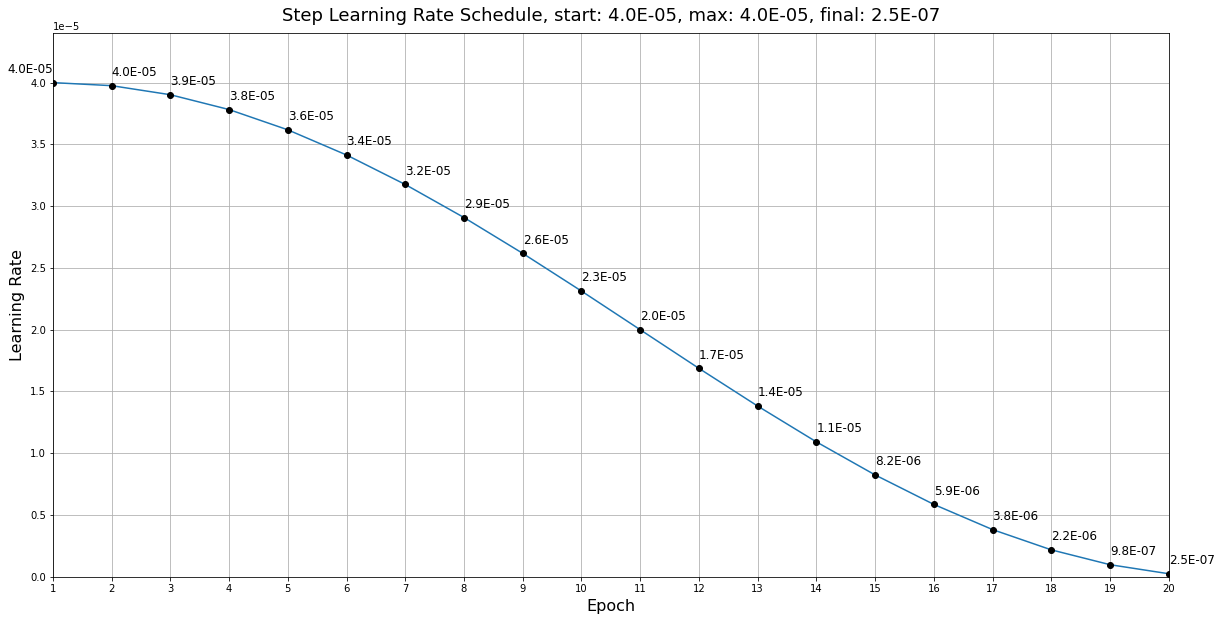

In [24]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=CFG.lr_ramp_ep, lr_max=CFG.lr_max, num_cycles=0.50) for step in range(CFG.epochs)]
plot_lr_schedule(LR_SCHEDULE, epochs=CFG.epochs)

In [25]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=CFG.wd_ratio):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [26]:
def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [27]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)


In [28]:
tf.config.optimizer.set_jit(True)

In [29]:
pf1_by_threshold = []
thresholds = np.arange(0, 1.01, 0.01)
for fold in range(1, CFG.num_folds):
    train_files = [file for file in files if eval(file.split('/')[-1].split('_')[1])%4. not in [fold]]
    val_files = [file for file in files if eval(file.split('/')[-1].split('_')[1])%4.== fold]
    
    train_ds = build_data(train_files)
    val_ds = build_data(val_files, val=True)
    #break  
    keras.backend.clear_session()
    gc.collect()
    with strategy.scope():
        model = build_model(activation='relu')
    #break
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f'convnetxt_tiny_rsna_weights_fold{fold}.h5',
                                monitor='val_pF1',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='max')
    callbacks = [lr_callback, checkpoint_cb]
    model.fit(train_ds, 
              validation_data=val_ds, 
              epochs=CFG.epochs,
              callbacks=callbacks,
              class_weight={0:1.,
                           1:5.}
             )
    #y_true_val = []
    #for i in val_ds:
       # y_true_val.append(i[-1])

    #y_true_val =  tf.concat(y_true_val, axis=0)
    #y_pred_val = model.predict(val_ds)
    #for t in thresholds:
    # Compute pF1 for each threshold
       # pf1_by_threshold.append(
        #    pfbeta(y_true_val, y_pred_val > t)
        #)
    
    

355221504/355218688 [==============================] - 14s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_base_384_imagenet21k-ft1k.h5
Epoch 1/20
262/262 [==============================] - 879s 2s/step - loss: 0.7965 - pF1: 0.0988 - f1_score: 0.0542 - precision: 0.0568 - recall: 0.0618 - binary_accuracy: 0.8841 - auc: 0.4942 - val_loss: 0.4017 - val_pF1: 0.0388 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.9799 - val_auc: 0.6256
Epoch 2/20
262/262 [==============================] - 577s 2s/step - loss: 0.7173 - pF1: 0.0893 - f1_score: 0.0178 - precision: 0.0404 - recall: 0.0115 - binary_accuracy: 0.9284 - auc: 0.4897 - val_loss: 0.3844 - val_pF1: 0.0408 - val_f1_score: 0.0152 - val_precision: 0.0833 - val_recall: 0.0083 - val_binary_accuracy: 0.9782 - val_auc: 0.6839
Epoch 3/20
262/262 [==============================] - 577s 2s/step - loss: 0.7605 - pF1: 0.1028 - f1_score: 0.0315 - precision: 0.0476 - recall: 

ResourceExhaustedError: 9 root error(s) found.
  (0) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 5
	 [[{{node cluster_train_function/_execute_5_0}}]]
  (1) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 1
	 [[{{node cluster_train_function/_execute_1_0}}]]
  (2) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 4
	 [[{{node cluster_train_function/_execute_4_0}}]]
  (3) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 2
	 [[{{node cluster_train_function/_execute_2_0}}]]
  (4) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 3
	 [[{{node cluster_train_function/_execute_3_0}}]]
  (5) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 6
	 [[{{node cluster_train_function/_execute_6_0}}]]
  (6) Cancelled: {{function_node __inference_train_function_364965}} RPC cancelled, not running TPU program on device 7
	 [[{{node cluster_train_function/_execute_7_0}}]]
  (7) Resource exhausted: {{function_node __inference_train_function_364965}} Attempting to allocate 621.85M. That was not possible. There are 886.77M free. Due to fragmentation, the largest contiguous region of free memory is 520.62M.; (0x0x0_HBM0)
	 [[{{node cluster_train_function/_execute_0_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[cluster_train_function/_execute_6_0/_75]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (8) Resource exhausted: {{function_node __inference_train_function_364965}} Attempting to allocate 621.85M. That was not possible. There are 886.77M free. Due to fragmentation, the largest contiguous region of free memory is 520.62M.; (0x0x0_HBM0)
	 [[{{node cluster_train_function/_execute_0_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
model.save(f'convnext_tiny_rsna.h5', include_optimizer=False)

In [ ]:
!cp /kaggle/input/rsna-bcd-convnetxt-tiny/convnetxt_tiny_rsna_weights_fold0.h5 /kaggle/working/